In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

#model related
import torch
import torchvision.models as models
from PIL import Image
import seaborn as sns

#statistical test and ploting: 
import time
import pickle

from itertools import combinations
from torch.nn import CosineSimilarity

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from help_functions import rename_images,run_sim_on_all_possible_pairs , create_image_matches_dataframe , process_and_extract_activations_from_folder, compare_image_similarity_pickled_features

c:\Users\User\Desktop\visual_memory_project\visual-memory-project\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# This is the name of the dataset of imges used , found in the relative project folder in the directory 
project_name = 'multicategory'

#similarity df related properties: 
model = models.vgg16(pretrained=False,dropout=0)
state_dict = torch.load("C:/Users/User/Desktop/vgg16-397923af.pth")
model.load_state_dict(state_dict)
model_name=model._get_name()

selected_nodes=['features.4','features.9','features.16','features.23','features.30','classifier.1','classifier.4']
selected_dictionary={node:'level_'+str(i) for i,node in enumerate(selected_nodes)}
create_similarity_df=True


c:\Users\User\Desktop\visual_memory_project\visual-memory-project\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\Desktop\visual_memory_project\visual-memory-project\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:


import torch.nn as nn
import torchvision.models as models


# Set the dropout layers' p attribute to zero
for module in model.modules():
    if isinstance(module, nn.Dropout):
        module.p = 0
        module.inplace = True

# Now the dropout layers in the VGG16 model have been set to zero


In [81]:

# Set the model to evaluation mode
model.eval()

# Define a list to store the feature maps
feature_maps = []

# Define a forward hook function that extracts the feature maps
def hook(module, input, output):
    feature_maps.append(output)

# Register the hook for all convolutional layers in the model
for module in model.features.modules():
    if isinstance(module, torch.nn.Conv2d):
        module.register_forward_hook(hook)

# Define an input tensor to the model
input_tensor = torch.randn(1, 3, 224, 224)

# Pass the input tensor through the model
output = model(input_tensor)

# Print the size of the feature maps for each layer
for i, feature_map in enumerate(feature_maps):
    print(f"Layer {i+1}: {feature_map.size()}")

# Clear the feature_maps list
feature_maps.clear()

Layer 1: torch.Size([1, 64, 224, 224])
Layer 2: torch.Size([1, 64, 224, 224])
Layer 3: torch.Size([1, 128, 112, 112])
Layer 4: torch.Size([1, 128, 112, 112])
Layer 5: torch.Size([1, 256, 56, 56])
Layer 6: torch.Size([1, 256, 56, 56])
Layer 7: torch.Size([1, 256, 56, 56])
Layer 8: torch.Size([1, 512, 28, 28])
Layer 9: torch.Size([1, 512, 28, 28])
Layer 10: torch.Size([1, 512, 28, 28])
Layer 11: torch.Size([1, 512, 14, 14])
Layer 12: torch.Size([1, 512, 14, 14])
Layer 13: torch.Size([1, 512, 14, 14])


In [77]:
# Print the input shape of each layer
# Print the input shape of each layer in the features module
for name, module in model.features.named_children():
    if isinstance(module, torch.nn.Conv2d):
        print(name, module.weight.size())
    elif isinstance(module, torch.nn.MaxPool2d):
        print(name, 'MaxPool')

0 torch.Size([64, 3, 3, 3])
2 torch.Size([64, 64, 3, 3])
4 MaxPool
5 torch.Size([128, 64, 3, 3])
7 torch.Size([128, 128, 3, 3])
9 MaxPool
10 torch.Size([256, 128, 3, 3])
12 torch.Size([256, 256, 3, 3])
14 torch.Size([256, 256, 3, 3])
16 MaxPool
17 torch.Size([512, 256, 3, 3])
19 torch.Size([512, 512, 3, 3])
21 torch.Size([512, 512, 3, 3])
23 MaxPool
24 torch.Size([512, 512, 3, 3])
26 torch.Size([512, 512, 3, 3])
28 torch.Size([512, 512, 3, 3])
30 MaxPool


In [70]:
import os
import shutil


to_rename = False 

if to_rename: 
    PATH_TO_RAW_DATA=Path.cwd().parent.parent.parent / 'projects' / project_name / 'raw data'


    # Loop over all the sub-folders
    for folder_name in os.listdir(PATH_TO_RAW_DATA):
        folder_path = os.path.join(PATH_TO_RAW_DATA, folder_name)
        
        # Loop over all the image files in the sub-folder
        for i, filename in enumerate(os.listdir(folder_path)):
            if filename.endswith(".jpg"):
                # Construct the new filename
                new_filename = folder_name + "_" + str(i) + ".jpg"
                old_file_path = os.path.join(folder_path, filename)
                new_file_path = os.path.join(folder_path, new_filename)
                
                # Rename the file
                shutil.move(old_file_path, new_file_path)
    

In [16]:
#this section assumes standartization - meaning that each relevant project has the same name for the 3 subfolders: 
PATH_TO_RAW_DATA=Path.cwd().parent.parent.parent / 'projects' / project_name / 'raw data'

PATH_TO_PROJECT = PATH_TO_RAW_DATA.parent
PATH_TO_PROCESSED_DATA=PATH_TO_RAW_DATA.parent.parent /  Path(PATH_TO_RAW_DATA.name + '_processed_'+ model_name)
PATH_TO_ACTIVATIONS_DATA=PATH_TO_RAW_DATA.parent /  Path(PATH_TO_RAW_DATA.name + '_features_'+ model_name)

PATHS_TO_EACH_RAW_IMG = list(PATH_TO_RAW_DATA.iterdir())

print('data locations:')
print('original images locatoin:\n',PATH_TO_RAW_DATA)
print('original processed (scaled and mean transformed) locatoin:\n',PATH_TO_PROCESSED_DATA)
print('original activations locatoin:\n',PATH_TO_ACTIVATIONS_DATA)

data locations:
original images locatoin:
 c:\Users\User\Desktop\visual_memory_project\visual-memory-project\projects\multicategory\raw data
original processed (scaled and mean transformed) locatoin:
 c:\Users\User\Desktop\visual_memory_project\visual-memory-project\projects\raw data_processed_VGG
original activations locatoin:
 c:\Users\User\Desktop\visual_memory_project\visual-memory-project\projects\multicategory\raw data_features_VGG


In [7]:
#take note that this code takes around 50 minutes to run (on 2250 images) - so if you dont need it (because you allready extracted activations, try to avoid it)
to_extract=False
if to_extract:
    print('processing and extracting activations')
    images_info,informative_nodes,informative_nodes_original = process_and_extract_activations_from_folder(PATH_TO_RAW_DATA,PATH_TO_RAW_DATA.parent,model,features_dict=selected_dictionary, images_type = 'jpg')
else:
    print('loading images info and informative nodes dictionary')
    images_info=pd.read_csv(PATH_TO_PROJECT/f'images_info_{project_name}.csv')
    images_info['sub_folder']=images_info['sub_folder'].fillna('')
    informative_nodes=pd.read_pickle(PATH_TO_PROJECT/'informative_nodes.pickle')
    informative_nodes_original=pd.read_pickle(PATH_TO_PROJECT/'informative_nodes.pickle')


loading images info and informative nodes dictionary


In [6]:
def run_sim_on_all_possible_pairs_with_range(FULL_PATH_PARENT_FOLDER,images_info_df,return_nodes_dict,model,iter_range=[]):

    model_name = model._get_name()
    model_features_folder_name = FULL_PATH_PARENT_FOLDER.name +'_features_' + model_name

    similarity_df=pd.DataFrame()
    all_pairs_length=len(list(combinations(images_info_df['img_name'].values,2)))
    if len(iter_range)==0:
        all_pairs=combinations(images_info_df['img_name'].values,2)
    elif len(iter_range)==2:
        all_pairs=list(combinations(images_info_df['img_name'].values,2))[iter_range[0]:iter_range[1]]
    else:
        raise Exception('iter_range should be a list of 2 values (left one is smaller)')


    cat1_tot = []
    cat2_tot = []

    for i,(im1_name,im2_name) in enumerate(all_pairs): 
        #estimate run time: 
        if i==0:
            start=time.time()

        cat1 = images_info_df[images_info_df['img_name'] == im1_name].iloc[0]['sub_folder']
        cat2 = images_info_df[images_info_df['img_name'] == im2_name].iloc[0]['sub_folder']

        cat1_tot.append(cat1)
        cat2_tot.append(cat2)

        distances,_=compare_image_similarity_pickled_features(FULL_PATH_PARENT_FOLDER,model_features_folder_name,im1_name.replace('.jpg','.pkl'),im2_name.replace('.jpg','.pkl'),cat1,cat2,CosineSimilarity(0))
        pair_line=pd.DataFrame(columns=['image1','image2']+list(return_nodes_dict.values()),index=[i])
        pair_line[['image1','image2','model']]=im1_name.replace('.jpg','.pkl'),im2_name.replace('.jpg','.pkl'),model_name
        pair_line[[colname for colname in pair_line.columns if colname in return_nodes_dict.values()]]=distances
        similarity_df=pd.concat([similarity_df,pair_line],axis=0)
        
        if i==0: 
            end=time.time()
            elapsed=end-start
            print(f'estimated time: first sample took {elapsed:.3f}, all pairs: {all_pairs_length} is estimated to take {elapsed*all_pairs_length/60:.3f} minutes')

        if np.mod(i,500)==0 and not(i==0):
            print(' iteration #', i)
    
    """if len( list(zip(cat1_tot,cat2_tot)))==0:
        similarity_df[['category1', 'category2']]=["",""]
    else:"""
    
    similarity_df[['category1', 'category2']] = list(zip(cat1_tot,cat2_tot))
        
    file_name = 'similarity_between_pairs_' + model_name + '_.csv'
    similarity_df.to_csv(file_name,index=False)    

    return similarity_df

In [112]:

import random
from itertools import combinations

all_activation = []
for image in random.sample(list((PATH_TO_ACTIVATIONS_DATA/Path('badlands')).iterdir()), 10):
    im1_file = open(image, "rb")
    im1_features_dict = pickle.load(im1_file)
    im1_file.close()
    layer_features_im1=im1_features_dict['level_0'].flatten()
    all_activation.append(layer_features_im1)
   

In [115]:
# Normalize the tensors in the list
for i in range(len(all_activation)):
    mean_tensor = torch.mean(all_activation[i])
    std_tensor = torch.std(all_activation[i])
    all_activation[i] = (all_activation[i] - mean_tensor) / std_tensor

In [120]:
total_no_th = []
for pair in combinations(all_activation,2):
    tensor1 = pair[0]
    tensor2 = pair[1]
    dist = CosineSimilarity(0)(tensor1,tensor2).detach().numpy()
    total_no_th.append(dist)

total_with_th = []
for pair in combinations(all_activation,2):
    tensor_means = torch.mean(torch.stack([pair[0], pair[1]], dim=1), dim=1)
    tensor1 = pair[0]
    tensor2 = pair[1]
    tensor1 = tensor1[tensor_means>0.5] 
    tensor2 = tensor2[tensor_means>0.5] 
    dist = CosineSimilarity(0)(tensor1,tensor2).detach().numpy()
    total_with_th.append(dist)



In [122]:
np.mean(total_no_th)

0.20868666

In [123]:
np.mean(total_with_th)

0.19497661

In [98]:
from torch.nn import CosineSimilarity

tensor_means = torch.mean(torch.stack([all_activation[0], all_activation[1]], dim=1), dim=1)

tensor1 = all_activation[0][tensor_means>0.5] 
tensor2 = all_activation[1][tensor_means>0.5] 

CosineSimilarity(0)(tensor1,tensor2).detach().numpy()




array(0.19000278, dtype=float32)

In [76]:


tensor_means = torch.mean(torch.stack([all_activation[0], all_activation[1]], dim=1), dim=1)
above_th = len(tensor_means[tensor_means<0.5])
total = len(all_activation[0])

above_th/total


0.8035926040338011

(array([1.56558e+05, 4.38570e+04, 4.46700e+04, 4.49490e+04, 4.51950e+04,
        4.26420e+04, 3.95560e+04, 3.69830e+04, 3.44810e+04, 3.24080e+04,
        2.98060e+04, 2.78560e+04, 2.51200e+04, 2.28950e+04, 1.98430e+04,
        1.75130e+04, 1.55220e+04, 1.37080e+04, 1.20800e+04, 1.05410e+04,
        9.38700e+03, 8.40200e+03, 7.58800e+03, 6.62900e+03, 5.97100e+03,
        5.33300e+03, 4.85800e+03, 4.30900e+03, 3.99700e+03, 3.68800e+03,
        3.09000e+03, 2.64300e+03, 2.48500e+03, 2.12800e+03, 1.91900e+03,
        1.70200e+03, 1.38400e+03, 1.26900e+03, 1.15400e+03, 1.03700e+03,
        9.01000e+02, 8.78000e+02, 7.14000e+02, 6.10000e+02, 5.44000e+02,
        5.39000e+02, 4.72000e+02, 3.83000e+02, 3.36000e+02, 2.69000e+02,
        2.47000e+02, 2.53000e+02, 1.88000e+02, 1.58000e+02, 1.56000e+02,
        1.34000e+02, 9.50000e+01, 1.05000e+02, 8.30000e+01, 5.90000e+01,
        6.80000e+01, 7.70000e+01, 6.30000e+01, 3.60000e+01, 3.00000e+01,
        4.90000e+01, 2.20000e+01, 1.90000e+01, 2.20

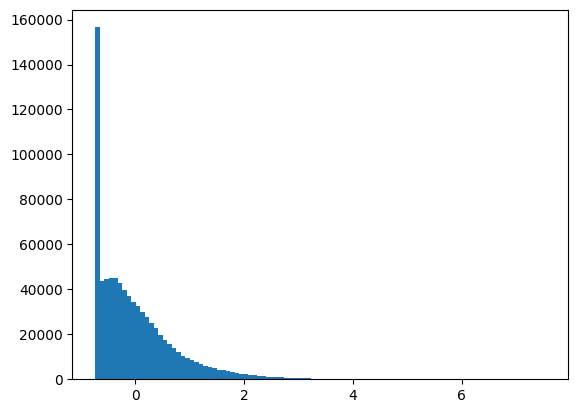

In [86]:
plt.hist(tensor_means.detach().numpy(),bins=100)

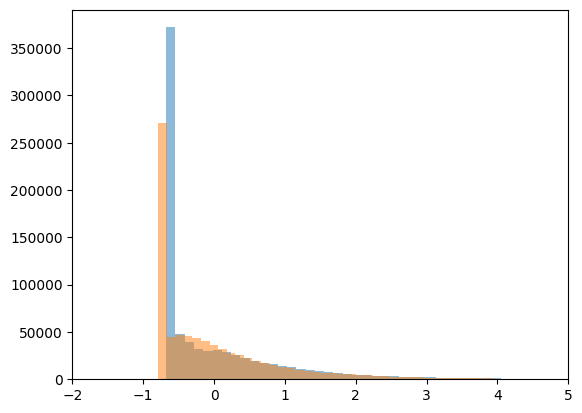

In [84]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Create a list of tensors
tensor_list = all_activation

# Convert the list of tensors into a NumPy array
tensor_array = torch.stack(tensor_list).detach().numpy()

# Flatten the NumPy array
flattened_array = np.ravel(tensor_array)

# Plot the histograms for each tensor
for i in range(tensor_array.shape[0]):
    plt.hist(tensor_array[i], alpha=0.5, label='Tensor {}'.format(i),bins=100)


plt.xlim((-2,5))

# Show the plot
plt.show()


In [9]:

cat_images_info = images_info[images_info['sub_folder'] == 'badlands']
similarity_df_cat = run_sim_on_all_possible_pairs(PATH_TO_RAW_DATA,cat_images_info.copy(),informative_nodes,model,True,1.5)


estimated time: first sample took 0.148, all pairs: 26796 is estimated to take 65.938 minutes
 iteration # 500
 iteration # 1000
 iteration # 1500
 iteration # 2000
 iteration # 2500
 iteration # 3000
 iteration # 3500
 iteration # 4000
 iteration # 4500
 iteration # 5000
 iteration # 5500
 iteration # 6000
 iteration # 6500
 iteration # 7000
 iteration # 7500
 iteration # 8000
 iteration # 8500
 iteration # 9000


KeyboardInterrupt: 

In [30]:

steps_before_saving=50000
start_from_enum_index=0 #should be 0 if starting fresh, or the iteration number that crashed (the index of the latest csv that is not full according to the step size)

PATH_TO_SEPERATED_CSVS=PATH_TO_PROJECT / 'seperated_similarity_csvs'
if not (PATH_TO_SEPERATED_CSVS).exists():
    print('created a folder to hold the seperated csvs')
    Path.mkdir(PATH_TO_SEPERATED_CSVS)

if create_similarity_df:
    # _features_VGG is added by "run_sim_on_all..."
    all_pairs=list(combinations(images_info['img_name'].values,2))
    all_timings=[]

    print('saving seperated files in:\n',PATH_TO_SEPERATED_CSVS)

    for i,ind in enumerate(np.arange(0,len(all_pairs),steps_before_saving)):
        if i>=start_from_enum_index:
            print('starting iteration index',i,ind)
            start=time.perf_counter()
            iter_range=[ind,min(ind+steps_before_saving,len(all_pairs))]
            temp_similarity_df = run_sim_on_all_possible_pairs_with_range(PATH_TO_RAW_DATA,images_info.copy(),informative_nodes,model,iter_range)
            temp_similarity_df.to_csv(PATH_TO_SEPERATED_CSVS / f'similarity_{project_name}_{i}.csv',index=False )
            all_timings.append(time.perf_counter()-start)
            print(all_timings)
            print('finished iteration index',i,ind)
        else:
            print(f'skipping iteration index {i}')


now read all the similarity csvs that were broken into 15000 rows pieces into a single "similarity_df" dataframe

In [31]:
#change to have the path where the seperated csvs were saved:
to_merge=False
if to_merge: 
    all_csvs=[file for file in PATH_TO_SEPERATED_CSVS.iterdir() if not 'all' in file.name]
    #load csvs into a single large matrix: 
    similarity_df=pd.DataFrame()
    for curr_csv in all_csvs:
        print('loading ',curr_csv)
        curr_df=pd.read_csv(curr_csv)
        similarity_df=pd.concat([similarity_df,curr_df])
        
    print('similarity_df was saved')
    similarity_df.to_csv(PATH_TO_PROJECT / f'similarity_{project_name}_all_{model_name}.csv')

['similarity_between_pairs_badlands_VGG.csv',
 'similarity_between_pairs_bridge_VGG.csv',
 'similarity_between_pairs_golf_course_VGG.csv',
 'similarity_between_pairs_highway_VGG.csv',
 'similarity_between_pairs_mountain_VGG.csv',
 'similarity_between_pairs_playground_VGG.csv']

In [13]:
to_load=True
if to_load:
    all_similarity_csv_names = [x for x in os.listdir(PATH_TO_PROJECT) if "similarity_between_pairs" in x]
    df_list = []
    for csv_name in all_similarity_csv_names:
    
    
        df_list.append(pd.read_csv(PATH_TO_PROJECT / csv_name))

similarity_df = pd.concat(df_list)

similarity_df.to_csv(PATH_TO_PROJECT / 'all_categories_similarity_df.csv')


<AxesSubplot: >

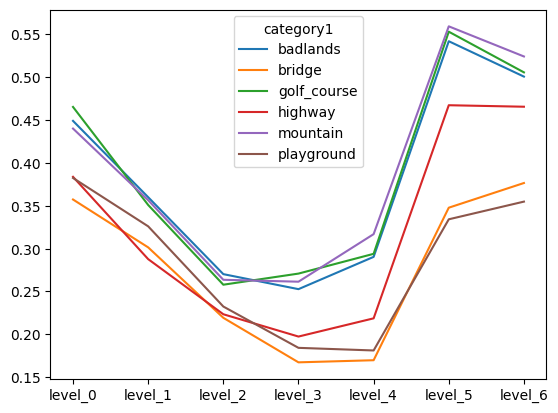

In [14]:
similarity_df.groupby('category1')[[col for col in similarity_df.columns if 'level' in col]].mean().T.plot()

<AxesSubplot: >

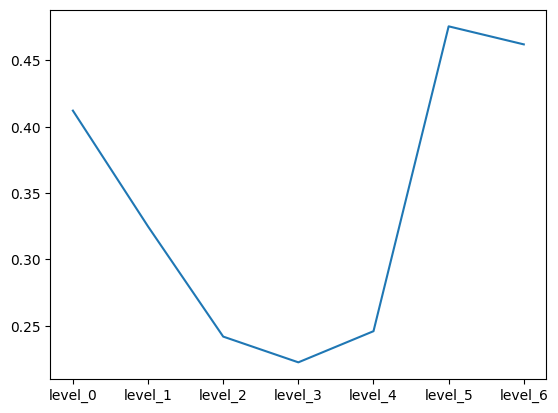

In [15]:
similarity_df[[col for col in similarity_df.columns if 'level' in col]].mean().plot()

          level_0   level_1   level_2   level_3   level_4   level_5   level_6
level_0  1.000000  0.819725  0.737284  0.744927  0.606416  0.560965  0.434185
level_1  0.819725  1.000000  0.891053  0.739857  0.587683  0.435499  0.313572
level_2  0.737284  0.891053  1.000000  0.854315  0.699550  0.532604  0.413346
level_3  0.744927  0.739857  0.854315  1.000000  0.860826  0.735537  0.588954
level_4  0.606416  0.587683  0.699550  0.860826  1.000000  0.853666  0.717733
level_5  0.560965  0.435499  0.532604  0.735537  0.853666  1.000000  0.915612
level_6  0.434185  0.313572  0.413346  0.588954  0.717733  0.915612  1.000000


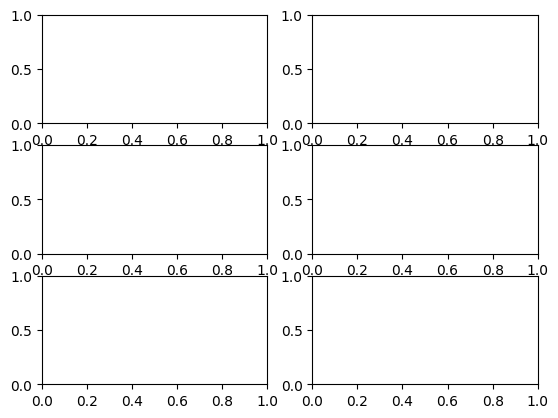

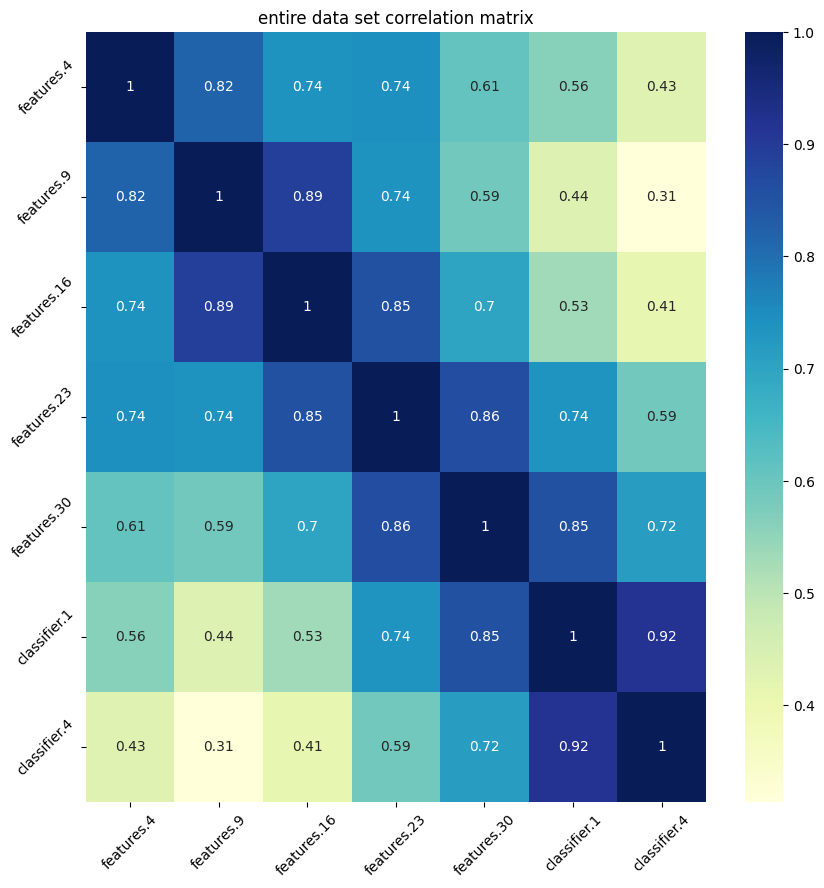

          level_0   level_1   level_2   level_3   level_4   level_5   level_6
level_0  1.000000  0.819725  0.737284  0.744927  0.606416  0.560965  0.434185
level_1  0.819725  1.000000  0.891053  0.739857  0.587683  0.435499  0.313572
level_2  0.737284  0.891053  1.000000  0.854315  0.699550  0.532604  0.413346
level_3  0.744927  0.739857  0.854315  1.000000  0.860826  0.735537  0.588954
level_4  0.606416  0.587683  0.699550  0.860826  1.000000  0.853666  0.717733
level_5  0.560965  0.435499  0.532604  0.735537  0.853666  1.000000  0.915612
level_6  0.434185  0.313572  0.413346  0.588954  0.717733  0.915612  1.000000


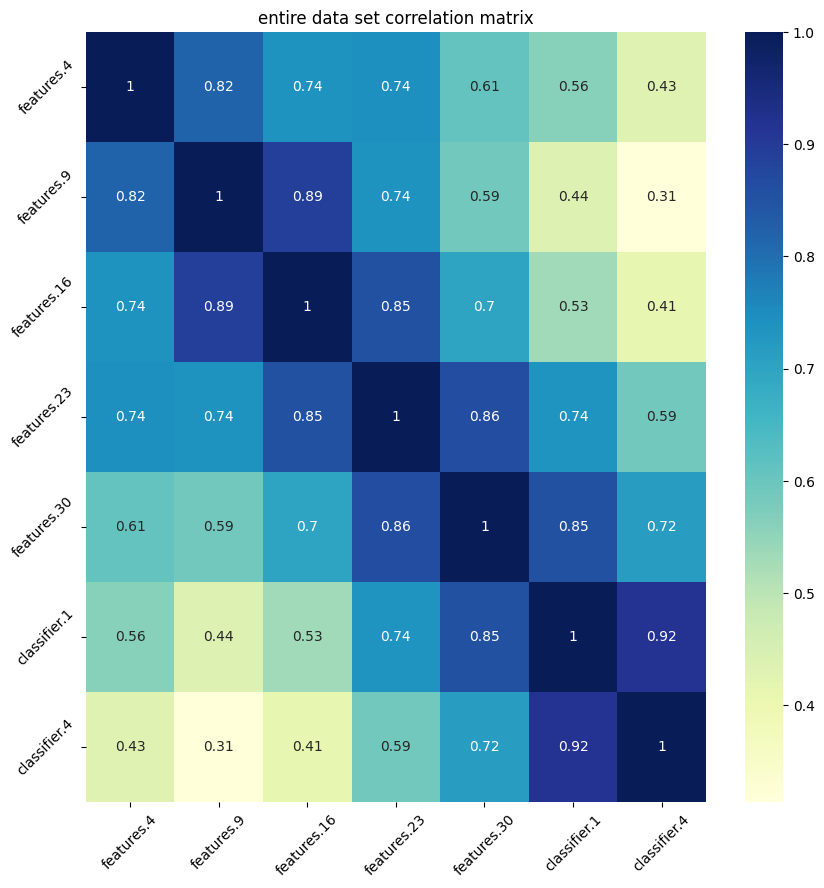

          level_0   level_1   level_2   level_3   level_4   level_5   level_6
level_0  1.000000  0.819725  0.737284  0.744927  0.606416  0.560965  0.434185
level_1  0.819725  1.000000  0.891053  0.739857  0.587683  0.435499  0.313572
level_2  0.737284  0.891053  1.000000  0.854315  0.699550  0.532604  0.413346
level_3  0.744927  0.739857  0.854315  1.000000  0.860826  0.735537  0.588954
level_4  0.606416  0.587683  0.699550  0.860826  1.000000  0.853666  0.717733
level_5  0.560965  0.435499  0.532604  0.735537  0.853666  1.000000  0.915612
level_6  0.434185  0.313572  0.413346  0.588954  0.717733  0.915612  1.000000


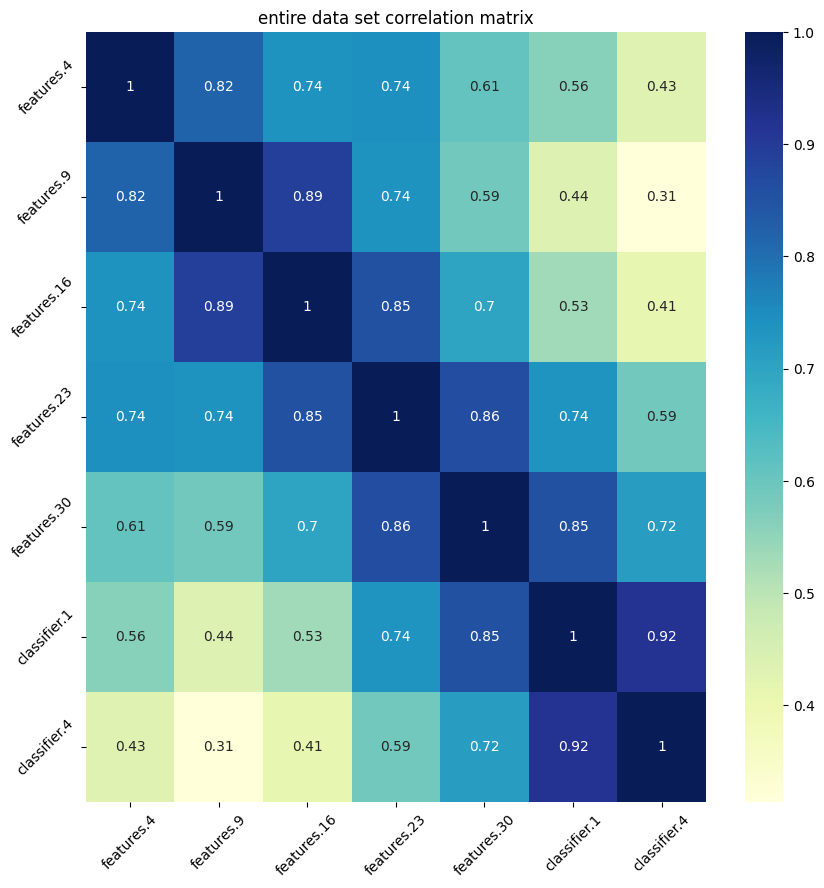

          level_0   level_1   level_2   level_3   level_4   level_5   level_6
level_0  1.000000  0.819725  0.737284  0.744927  0.606416  0.560965  0.434185
level_1  0.819725  1.000000  0.891053  0.739857  0.587683  0.435499  0.313572
level_2  0.737284  0.891053  1.000000  0.854315  0.699550  0.532604  0.413346
level_3  0.744927  0.739857  0.854315  1.000000  0.860826  0.735537  0.588954
level_4  0.606416  0.587683  0.699550  0.860826  1.000000  0.853666  0.717733
level_5  0.560965  0.435499  0.532604  0.735537  0.853666  1.000000  0.915612
level_6  0.434185  0.313572  0.413346  0.588954  0.717733  0.915612  1.000000


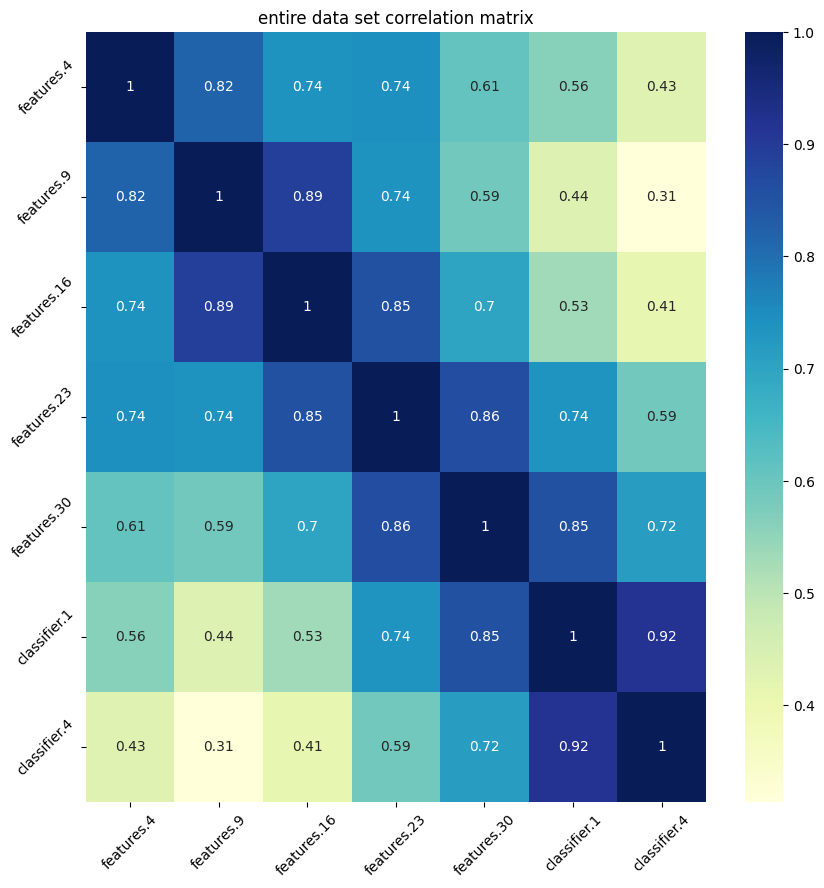

          level_0   level_1   level_2   level_3   level_4   level_5   level_6
level_0  1.000000  0.819725  0.737284  0.744927  0.606416  0.560965  0.434185
level_1  0.819725  1.000000  0.891053  0.739857  0.587683  0.435499  0.313572
level_2  0.737284  0.891053  1.000000  0.854315  0.699550  0.532604  0.413346
level_3  0.744927  0.739857  0.854315  1.000000  0.860826  0.735537  0.588954
level_4  0.606416  0.587683  0.699550  0.860826  1.000000  0.853666  0.717733
level_5  0.560965  0.435499  0.532604  0.735537  0.853666  1.000000  0.915612
level_6  0.434185  0.313572  0.413346  0.588954  0.717733  0.915612  1.000000


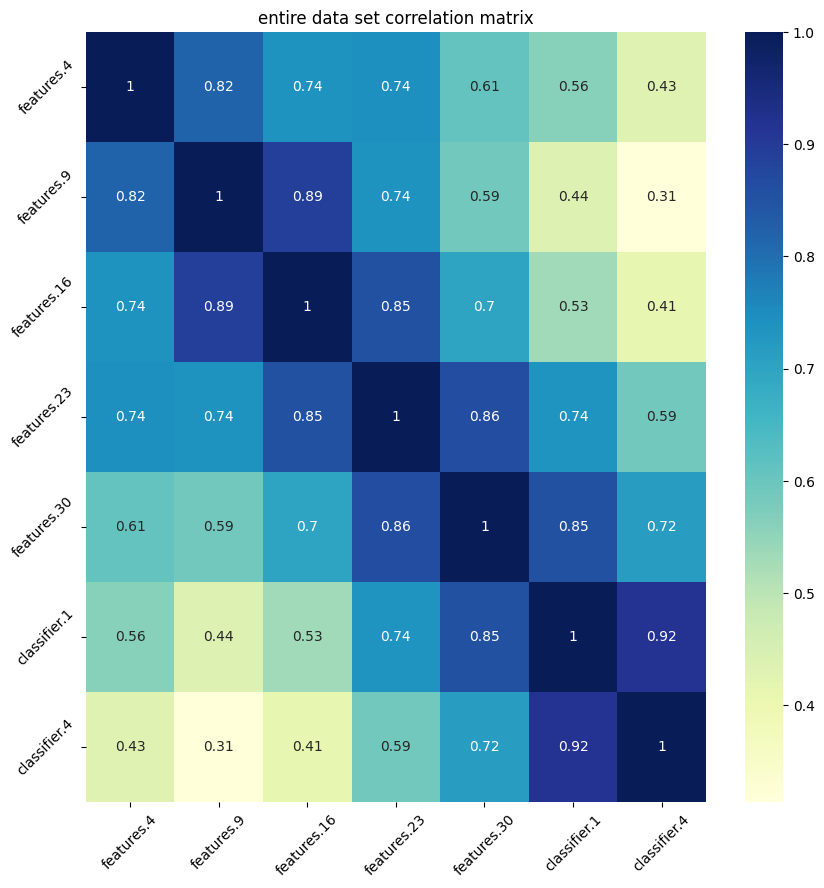

          level_0   level_1   level_2   level_3   level_4   level_5   level_6
level_0  1.000000  0.819725  0.737284  0.744927  0.606416  0.560965  0.434185
level_1  0.819725  1.000000  0.891053  0.739857  0.587683  0.435499  0.313572
level_2  0.737284  0.891053  1.000000  0.854315  0.699550  0.532604  0.413346
level_3  0.744927  0.739857  0.854315  1.000000  0.860826  0.735537  0.588954
level_4  0.606416  0.587683  0.699550  0.860826  1.000000  0.853666  0.717733
level_5  0.560965  0.435499  0.532604  0.735537  0.853666  1.000000  0.915612
level_6  0.434185  0.313572  0.413346  0.588954  0.717733  0.915612  1.000000


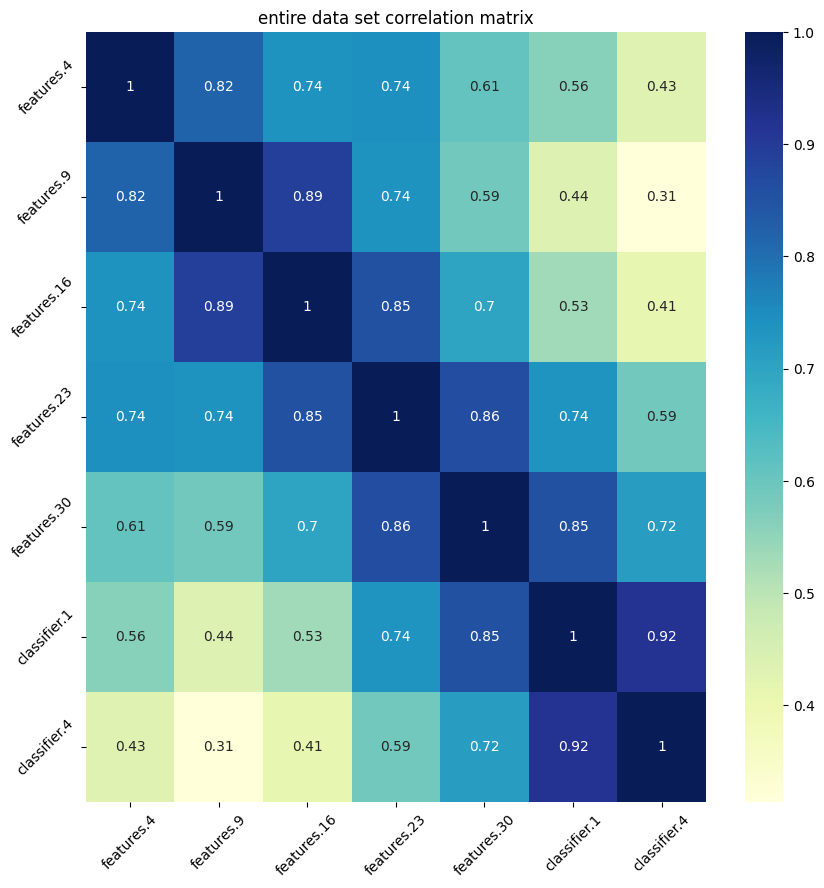

In [16]:
# import modules
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

fig,ax = plt.subplots(3,2)
ax.ravel()

grouped_similarity_df = similarity_df.groupby('category1')

for a,b in grouped_similarity_df:

    sim_level_colnames=[colname for colname in similarity_df.columns if 'level' in colname]
    print(similarity_df[sim_level_colnames].corr())
    fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    dataplot = sns.heatmap(similarity_df[sim_level_colnames].corr(), cmap="YlGnBu", annot=True,ax=axes)
    # displaying heatmap
    axes.set_title('entire data set correlation matrix')
    axes.set_xticks(ticks=axes.get_xticks(),labels=selected_nodes,rotation=45)
    axes.set_yticks(ticks=axes.get_yticks(),labels=selected_nodes,rotation=45)
    plt.show()

fig.savefig(PATH_TO_PROJECT / 'data_set_extracted_layer_correlation_matrix.svg')



In [62]:
selected_nodes

['features.4',
 'features.9',
 'features.16',
 'features.23',
 'features.30',
 'classifier.1',
 'classifier.4']

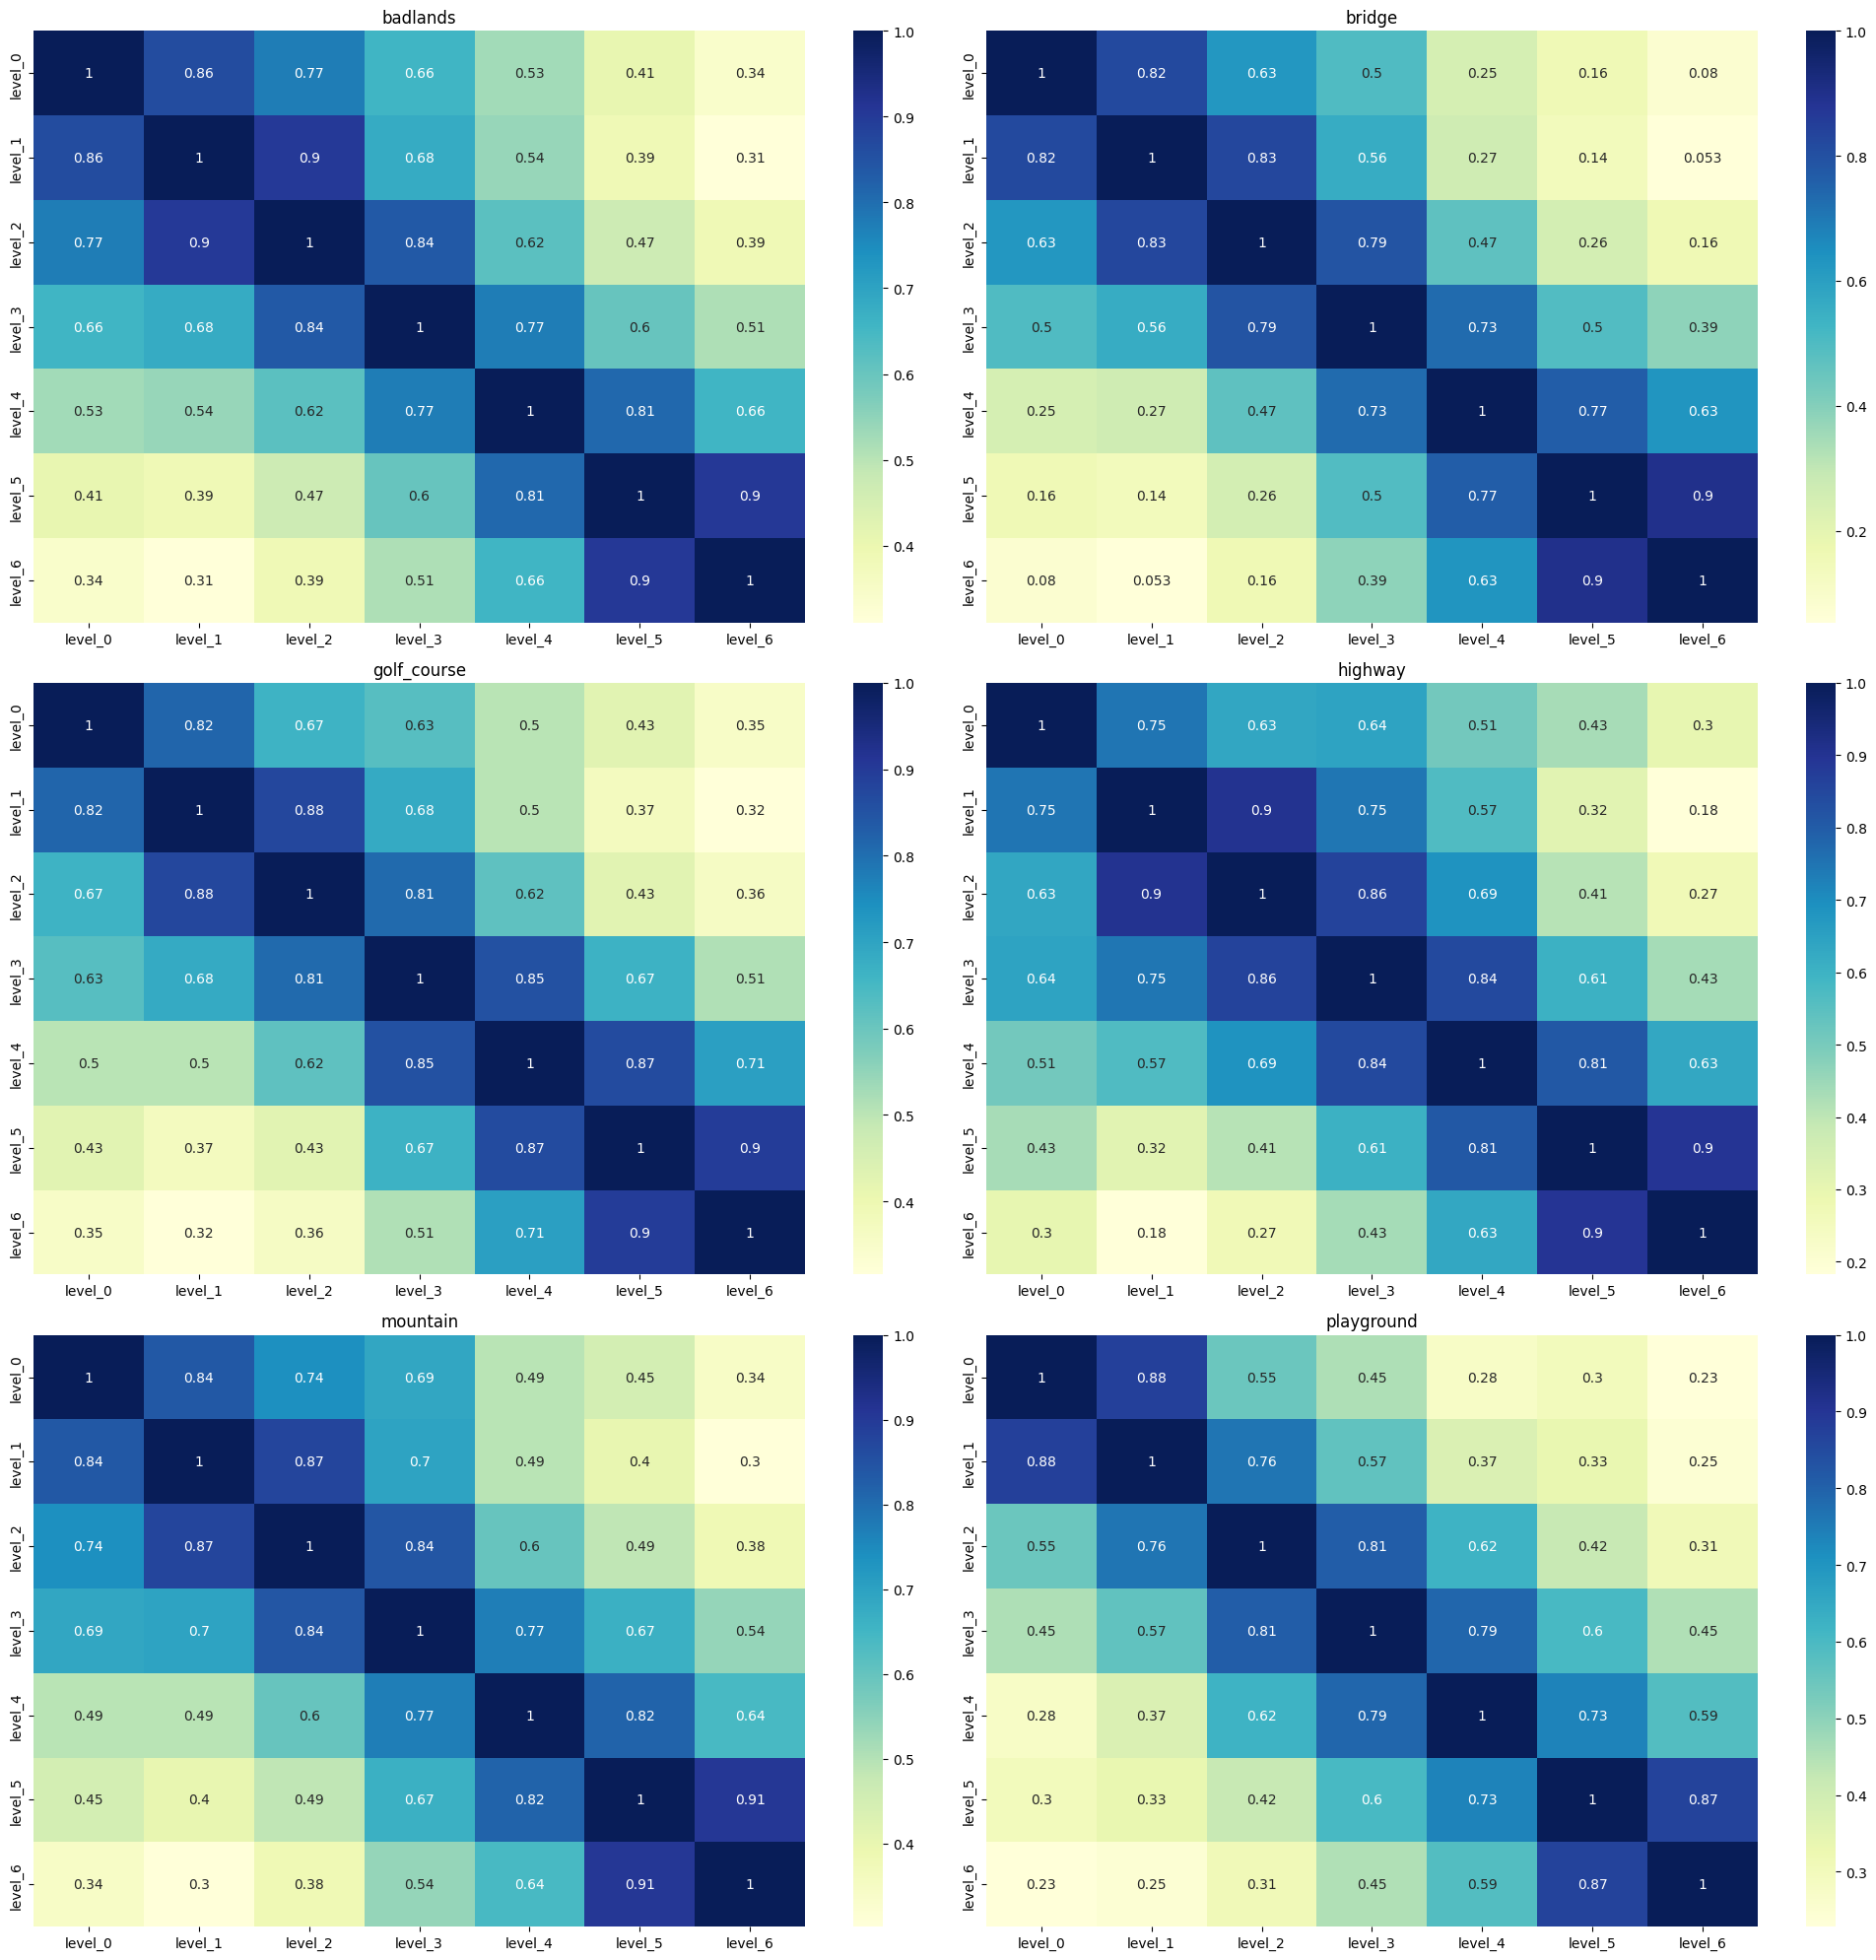

In [64]:
fig,axes = plt.subplots(3,2,figsize = (20,20))
axes = axes.ravel()
grouped_similarity_df = similarity_df.groupby('category1')

for i,(group_name,group_df) in enumerate(grouped_similarity_df):
    sim_level_colnames=[colname for colname in similarity_df.columns if 'level' in colname]
    dataplot = sns.heatmap(group_df[sim_level_colnames].corr(), cmap="YlGnBu", annot=True,ax=axes[i])
    # displaying heatmap
    axes[i].set_title(group_name)
    #axes[i].set_xticks(ticks=axes[i].get_xticks(),labels=selected_nodes,rotation=45)
    #axes[i].set_yticks(ticks=axes[i].get_yticks(),labels=selected_nodes,rotation=45)

fig.tight_layout()  

fig.savefig(PATH_TO_PROJECT / 'data_set_extracted_layer_correlation_matrix_per_group.svg')